In [1]:
!pip install missingno
!pip install prettytable
!pip install yellowbrick
!pip install gap-stat
!pip install optuna
!pip install catboost category-encoders imbalanced-learn lightgbm xgboost
!pip install category_encoders
!pip install -U imbalanced-learn

In [2]:
!pip install --progress-bar off --upgrade --quiet autogluon

In [1]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
import copy
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from autogluon.tabular import TabularPredictor


import joblib 

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

/opt/conda/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
sub1 = pd.read_csv("voted_hoxi_mola2.csv")
sub2 = pd.read_csv("isitright.csv")
sub3 = pd.read_csv("gang2.csv")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
origin = pd.read_csv('horse.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train = train.replace('None', np.NaN)
test = test.replace('None', np.NaN)
origin = origin.replace('None', np.NaN)

In [4]:
concatenated_df = pd.concat([ sub1["outcome"], sub2["outcome"],sub3['outcome']], axis=1)
same_categories = concatenated_df.apply(lambda row: row.nunique() == 1, axis=1)
df_same_categories = concatenated_df[same_categories]
df_same_categories

,outcome,outcome,outcome
0,lived,lived,lived
1,died,died,died
2,lived,lived,lived
3,euthanized,euthanized,euthanized
4,lived,lived,lived
...,...,...,...
819,died,died,died
820,euthanized,euthanized,euthanized
821,died,died,died
822,lived,lived,lived


In [5]:
different_categories=concatenated_df.apply(lambda row: row.nunique()> 1, axis=1)
df_different_categories = concatenated_df[different_categories]
df_different_categories

,outcome,outcome,outcome
12,lived,euthanized,lived
36,lived,died,lived
39,lived,euthanized,lived
48,died,lived,lived
76,lived,euthanized,lived
...,...,...,...
729,lived,died,lived
778,died,lived,died
792,lived,euthanized,lived
817,died,lived,died


In [6]:
print(df_different_categories.index.tolist())

[12, 36, 39, 48, 76, 88, 110, 111, 118, 128, 132, 145, 149, 152, 170, 187, 195, 218, 234, 242, 276, 278, 307, 317, 329, 336, 366, 370, 373, 379, 387, 389, 394, 406, 410, 431, 446, 464, 487, 489, 493, 502, 515, 517, 529, 530, 544, 545, 547, 549, 561, 563, 585, 591, 592, 601, 604, 606, 623, 630, 662, 693, 695, 696, 707, 717, 729, 778, 792, 817, 818]


In [7]:
all_different_categories=concatenated_df.apply(lambda row: row.nunique()> 2, axis=1)
df_all_different_categories= concatenated_df[all_different_categories]
df_all_different_categories

,outcome,outcome,outcome


In [8]:
print(df_all_different_categories.index.tolist())

[]


In [9]:
sub=sub1.copy()

concatenated_df = pd.concat([sub1["outcome"], sub2["outcome"],sub3['outcome']], axis=1)
has_euthanized = (concatenated_df == "euthanized").any(axis=1) # & (concatenated_df != "lived").any(axis=1)

concatenated_df['euthanized'] = has_euthanized

concatenated_df['vote']=concatenated_df.drop(columns=['euthanized']).mode(axis=1).iloc[:, 0]
concatenated_df['vote']=np.where((concatenated_df['euthanized']==True) & (concatenated_df['vote']!="lived"), "euthanized", concatenated_df['vote'])
# concatenated_df.loc[df_all_different_categories.index.tolist(),'vote']="euthanized"
sub["outcome"]=concatenated_df['vote']

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


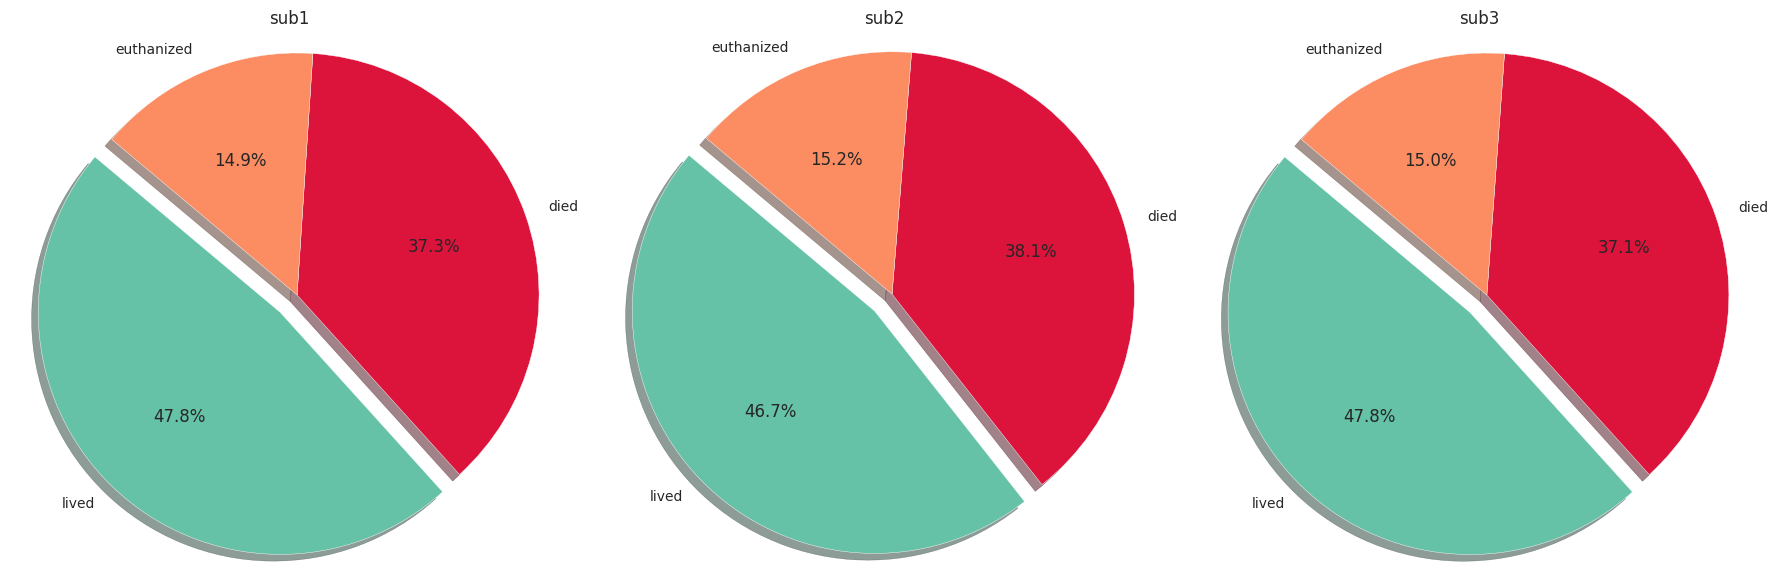

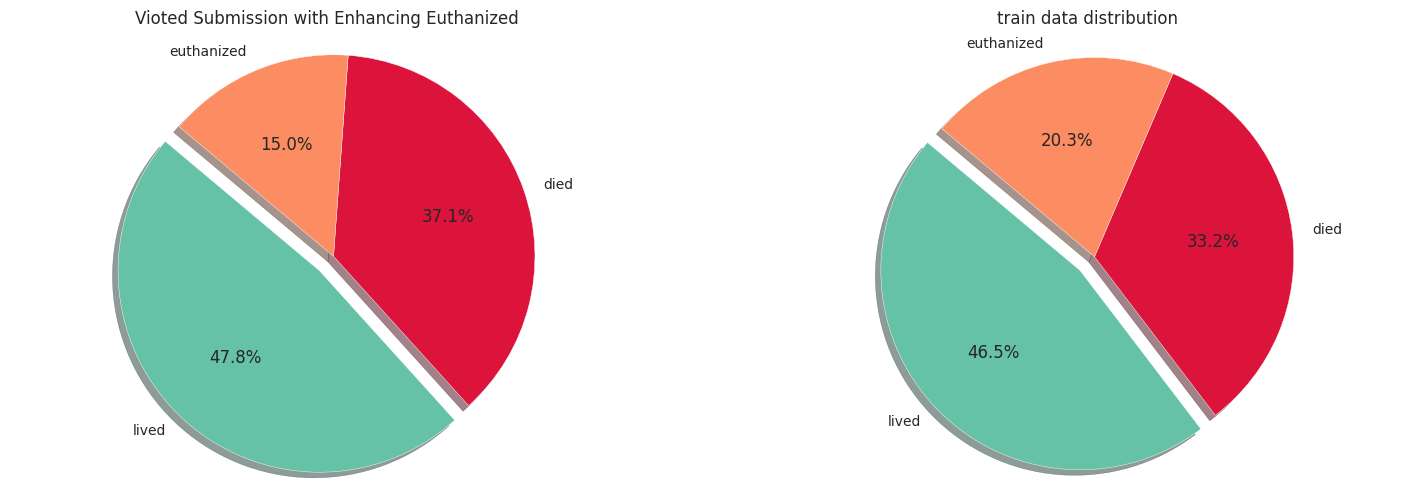

In [10]:
def plot_pie_chart(data, title, ax):
    data_counts = data['outcome'].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.4, 0.76, 0.65), 'crimson',  (0.99, 0.55, 0.38)]  
    explode = (0.1, 0, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(sub1, "sub1", axes[0])
plot_pie_chart(sub2, "sub2", axes[1])
plot_pie_chart(sub3, "sub3", axes[2])
# plot_pie_chart(sub4, "sub4", axes[3])
# plot_pie_chart(sub5, "sub5", axes[4])
# plot_pie_chart(sub6, "sub6", axes[5])


plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(sub, "Vioted Submission with Enhancing Euthanized", axes[0])
plot_pie_chart(train, "train data distribution", axes[1])

In [13]:
sub.to_csv('voted_final.csv',index=False)
sub.head()

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived


In [14]:
train = pd.read_csv("train_cleaned.csv")
test = pd.read_csv("test_cleaned.csv")

In [15]:
final_features=[f for f in train.columns if f not in ['outcome']]
final_features=[*set(final_features)]
sc=StandardScaler()

train_scaled=train.copy()
test_scaled=test.copy() #.drop(columns=['id'])
train_scaled[final_features]=sc.fit_transform(train[final_features])
test_scaled[final_features]=sc.transform(test[final_features])

def post_processor(train, test):
    cols=train.drop(columns=['outcome']).columns
    train_cop=train.copy()
    test_cop=test.copy()
    drop_cols=[]
    for i, feature in enumerate(cols):
        for j in range(i+1, len(cols)):
            if sum(abs(train_cop[feature]-train_cop[cols[j]]))==0:
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])
    print(drop_cols)
    train_cop.drop(columns=drop_cols,inplace=True)
    test_cop.drop(columns=drop_cols,inplace=True)
    
    return train_cop, test_cop

                    
train_cop, test_cop=   post_processor(train_scaled, test_scaled)            

X_train = train_cop.drop(columns=['outcome'])
y_train = train['outcome']

X_test = test_cop.copy()

print(X_train.shape, X_test.shape)

"""
X_train = train[final_features]
y_train = train['outcome']
X_test = test[final_features]
"""

['yes_surgerysurgery', 'yes_surgical_lesionsurgical_lesion', 'lesion_2_1_count', 'lesion_2_1_count_label', 'NA_1_lesion_2_1lesion_2_1', 'Gastric_lesion_2_1lesion_2_1', 'Large_Colon_lesion_2_1lesion_2_1', 'Transverse_Colon_lesion_2_1lesion_2_1', 'yes_cp_datacp_data', '0original', 'Other_2_lesion_2_2lesion_2_2', 'lesion_2_3_target', 'NA3_lesion_2_3lesion_2_3', 'NA4_lesion_2_4lesion_2_4']
(1503, 211) (824, 211)


"\nX_train = train[final_features]\ny_train = train['outcome']\nX_test = test[final_features]\n"

In [16]:
for i in list(X_test.columns):
    if i not in list(X_train.columns):
        print(i)

In [17]:
target_map={
    "lived":0,
    "died": 1,
    "euthanized":2
}     

def encode(y,target_map):
    '''
    To convert the outputs to numbers
    '''
    y=np.array(y)
    encoded_y=[target_map[f] for f in y]
    return encoded_y
def decode(y,target_map):
    '''To convert the predictions back to classes
    '''
    y=np.array(y)
    reverse_dict={v: k for k, v in target_map.items()}
    decoded_y=[reverse_dict[f] for f in y]
    return decoded_y

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

X_train_cop = X_train.copy()
X_test_cop = X_test.copy()

def closest_index(X_test_cop, X_train_cop, index_test, num_closest=500):
    res = [] 
    for i in index_test:
        test_point = np.array(X_test_cop.loc[i]).reshape(1, -1)  
        similarities = cosine_similarity(X_train_cop, test_point)  
        closest_indices = np.argsort(similarities[:, 0])[-num_closest:][::-1] 
        res.append(closest_indices)  
    return np.array(res)

res = closest_index(X_test_cop, X_train_cop, df_all_different_categories.index.tolist())
res=res.reshape(1,-1)[0]
print("Closest indexes in X_train:", res)

Closest indexes in X_train: []


In [19]:
res=[*set(res)]
print(f"Among {X_train.shape[0]} data points in the train, we have identified {len(res)} , it also means some of them got eliminated")

Among 1503 data points in the train, we have identified 0 , it also means some of them got eliminated


In [20]:
X_train=X_train.loc[res]
y_train=y_train.loc[res]

X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True) #.map(({0: 'died', 1: 'lived', 2:'euthanized'}))


import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [21]:
def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    lgb_params = {
            'n_estimators': 200,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
    cb_params = {
            'iterations': 200,
            'depth': 7,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
            'random_state': 42,
        }
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    else:
        model=lgb.LGBMClassifier(**lgb_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, encode(y_train_fold,target_map), verbose=False)
        
        y_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(encode(y_val_fold,target_map), y_pred, average='micro'))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_f1 = np.mean(f1_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:25]
    
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 15))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {25} of {n} Feature Importances with best F1 score {avg_f1}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features

In [22]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'xgb')
n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'lgbm')

n_imp_features=[*set(n_imp_features_xgb+n_imp_features_lgbm+n_imp_features_cat)]
#n_imp_features=[*set(n_imp_features_xgb+n_imp_features_cat)]

print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

X_train=X_train[n_imp_features]
X_test=X_test[n_imp_features]

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

In [ ]:
classes = np.unique(y_train)  # Get unique class labels
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {target_map[cls]: weight for cls, weight in zip(classes, class_weights)}

print("Class counts:", class_counts)
print("Total samples:", total_samples)
print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

In [ ]:
"""
class_weights_dict[0]=1
class_weights_dict[1]=0.1
class_weights_dict[2]=10
"""

In [ ]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.05,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'merror',
            'objective': 'multi:softmax',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
            
        xgb_params2=xgb_params.copy() 
        xgb_params2['subsample']= 0.3
        xgb_params2['max_depth']=8
        xgb_params2['learning_rate']=0.005
        xgb_params2['colsample_bytree']=0.9

        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 8,
            'learning_rate': 0.02,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        lgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 5,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        lgb_params3=lgb_params.copy()  
        lgb_params3['subsample']=0.9
        lgb_params3['reg_lambda']=0.3461495211744402
        lgb_params3['reg_alpha']=0.3095626288582237
        lgb_params3['max_depth']=9
        lgb_params3['learning_rate']=0.007
        lgb_params3['colsample_bytree']=0.5

                
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 6,
            'learning_rate': 0.05,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'TotalF1',
            'loss_function': 'MultiClass',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'
        
        cb_params2=  cb_params.copy()
        cb_params2['learning_rate']=0.01
        cb_params2['depth']=8
        
        cb_params3={
            'iterations': self.n_estimators,
            'random_strength': 0.1, 
            'one_hot_max_size': 70, 'max_bin': 100, 
            'learning_rate': 0.008, 
            'l2_leaf_reg': 0.3, 
            'grow_policy': 'Depthwise', 
            'depth': 9, 
            'max_bin': 200,
            'od_wait': 65,
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'TotalF1',
            'loss_function': 'MultiClass',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        models = {
            'svc': SVC(gamma="auto", probability=True, random_state=self.random_state),
            'xgb': xgb.XGBClassifier(**xgb_params),
            'xgb2': xgb.XGBClassifier(**xgb_params2),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'lgb2': lgb.LGBMClassifier(**lgb_params2),
            'lgb3': lgb.LGBMClassifier(**lgb_params3),
            'cat': CatBoostClassifier(**cb_params),
            "cat_sym": CatBoostClassifier(**cb_sym_params),
            "cat_loss": CatBoostClassifier(**cb_loss_params),
            'cat2': CatBoostClassifier(**cb_params2),
            'brf': BalancedRandomForestClassifier(n_estimators=4000, n_jobs=-1, random_state=self.random_state),
            'rf': RandomForestClassifier(n_estimators=1000, random_state=self.random_state),
            'hist_gbm' : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,  max_leaf_nodes=80,
                                                         max_depth=6,class_weight=class_weights_dict, random_state=self.random_state)
        }
        return models

In [ ]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=5000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", -1, 2) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        weighted_pred_labels = np.argmax(weighted_pred, axis=1)
        f1_micro_score = f1_score(y_true, weighted_pred_labels, average='micro')
        return f1_micro_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [ ]:
kfold = True
n_splits = 1 if not kfold else 5
random_state = 42
random_state_list = [42] 
n_estimators = 9999 
early_stopping_rounds = 200
verbose = False
device = 'cpu'
splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros((X_test.shape[0], 3))
ensemble_score = []
ensemble_f1_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[]}
    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name)  :
            model.fit(X_train_, encode(y_train_,target_map), eval_set=[(X_val, encode(y_val,target_map))], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, encode(y_train_,target_map))
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict_proba(X_test)
        y_val_pred = model.predict_proba(X_val)

        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        f1_micro_score = f1_score(encode(y_val,target_map), y_val_pred_labels, average='micro')
        
        score = log_loss(encode(y_val,target_map), y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] F1 Micro Score: {f1_micro_score:.5f}, Logloss: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(encode(y_val,target_map), oof_preds)
    
    score = log_loss(encode(y_val,target_map), y_val_pred)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    f1_micro_score = f1_score(encode(y_val,target_map), y_val_pred_labels, average='micro')
    
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] ---------------> F1 Micro Score: {f1_micro_score:.5f}, Logloss: {score:.5f}')
    
    ensemble_score.append(score)
    ensemble_f1_score.append(f1_micro_score)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    _test_preds = optweights.predict(test_preds)
    test_predss += _test_preds / (n_splits * len(random_state_list))
    
    gc.collect()

In [ ]:
# Calculate the mean F1 Score score of the ensemble
mean_score = np.mean(ensemble_f1_score)
std_score = np.std(ensemble_f1_score)
print(f'Ensemble F1 score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['outcome'] =  decode(np.argmax(test_predss, axis=1),target_map)
submission.loc[sub[same_categories].index,"outcome"]=sub.loc[sub[same_categories].index,"outcome"]
submission.to_csv('thisismyfinal3.csv',index=False)
submission.head()